# Instead of test the algorithms and affinity on the whole dataset, this notebook test data from each trial, which is what we need in implementation.

# With anchor object

<IPython.core.display.Javascript object>


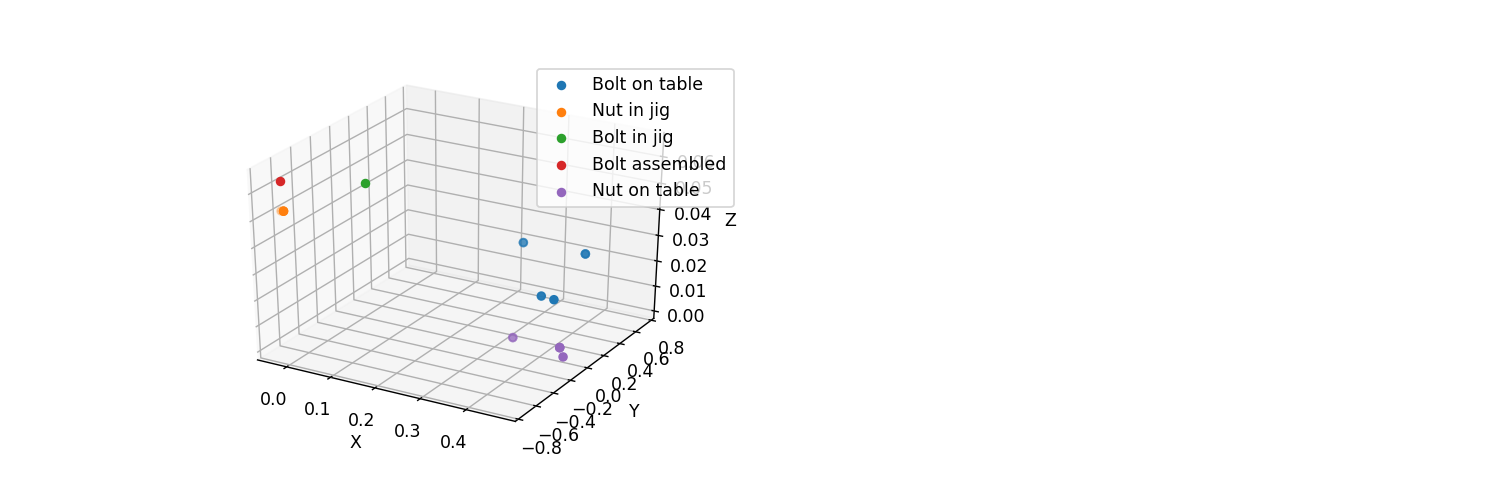

In [1]:
import numpy as np
%matplotlib notebook
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from utils.data import fetch_data, fetch_data_with_label, fetch_data_with_label_per_step, generate_data, label_to_int, divide_data
from utils.plotting import plot
from utils.clustering import agglomerative, kmeans, gaussian_mixture, Clustering
from sklearn.metrics import adjusted_rand_score
import itertools


logfile_path = ['../data/raw/1599166289/data.pickle', '../data/raw/1599153598/data.pickle', '../data/raw/test/data.pickle']

#coordinates and object kind for nut and bolt
data_concat, label = fetch_data_with_label_per_step(logfile_path)

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))


coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

fig = plt.figure(1, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord, selected_label)


In [2]:
def balance_data(data, labels):
    count = []
    for label in set(labels):
        count.append((labels == label).sum())
    max_count = max(count)
    for label in set(labels):
        n_data = (labels == label).sum()
        if n_data < max_count:
            ind = np.where(labels == label)[0]
            selected_data = data[ind, :]
            average = np.average(selected_data, axis = 0)
            n_needed = max_count - n_data
            data_needed = np.tile(average, (n_needed, 1))
            label_needed = np.tile(label, n_needed)
            data = np.concatenate((data, data_needed), axis = 0)
            labels = np.concatenate((labels, label_needed))
    return data, labels

# Agglomerative with P-nom and number of clusters. Object kind, anchor object are used as a soft constrain.

<IPython.core.display.Javascript object>


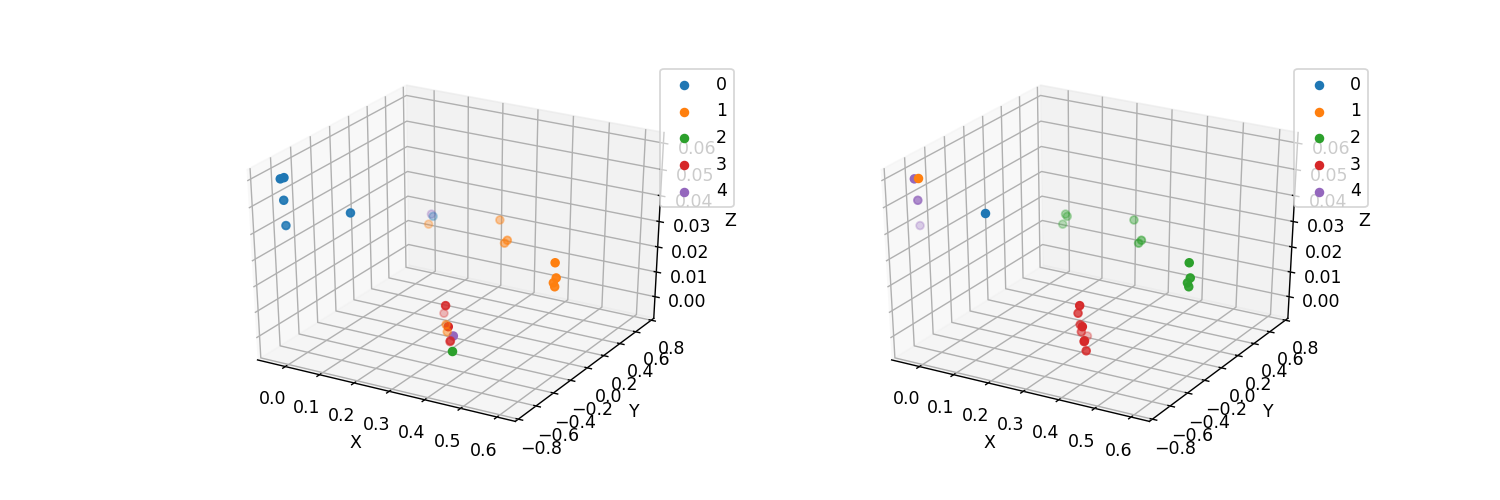

The accuracy for nut and bolt is 0.291843220338983


In [67]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat = agglomerative(coord_concat_ext, 'p_norm', thres = None, n_clusters = 5, p = -2)
n_original = selected_data.shape[0]

fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

In [65]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat = agglomerative(coord_concat_ext, 'p_norm', thres = None, n_clusters = 5, p = -2)
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.6059418817124436


# Agglomerative with Euclidean and number of clusters. Object kind, anchor object are used as a soft constrain.

<IPython.core.display.Javascript object>


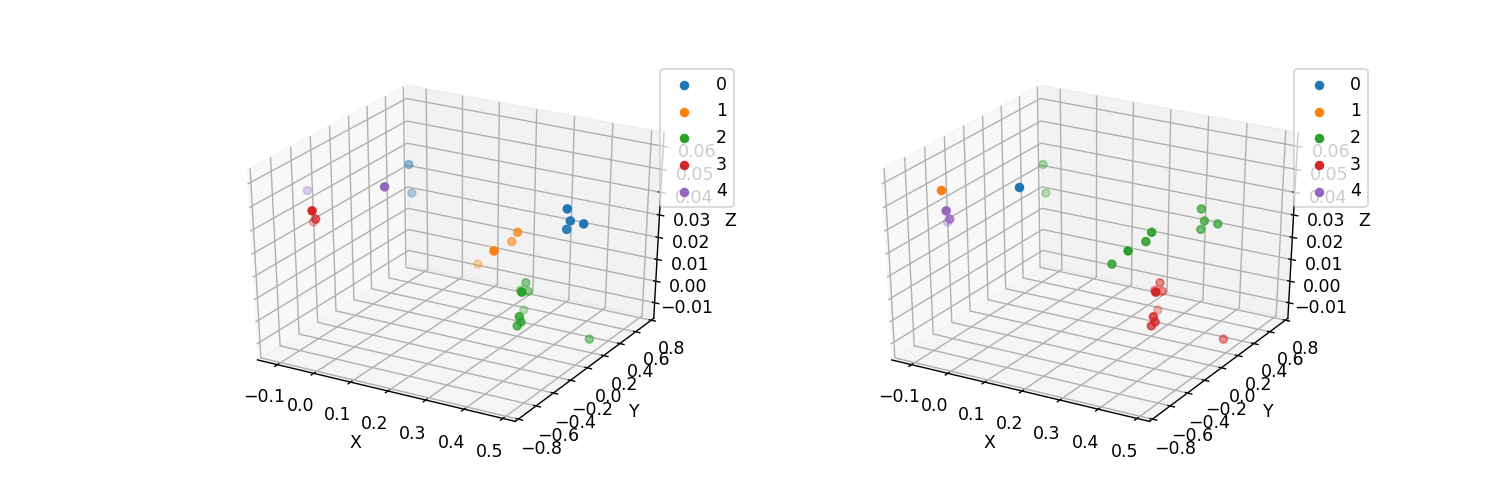

The accuracy for nut and bolt is 0.7015130674002751


In [77]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat = agglomerative(coord_concat_ext, 'euclidean', thres = None, n_clusters = 5)
n_original = selected_data.shape[0]

fig = plt.figure(3, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

In [69]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat = agglomerative(coord_concat_ext, 'euclidean', thres = None, n_clusters = 5)
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8338909246085734


# Agglomerative with Cosine and number of clusters. Object kind, anchor object are used as a soft constrain.

<IPython.core.display.Javascript object>


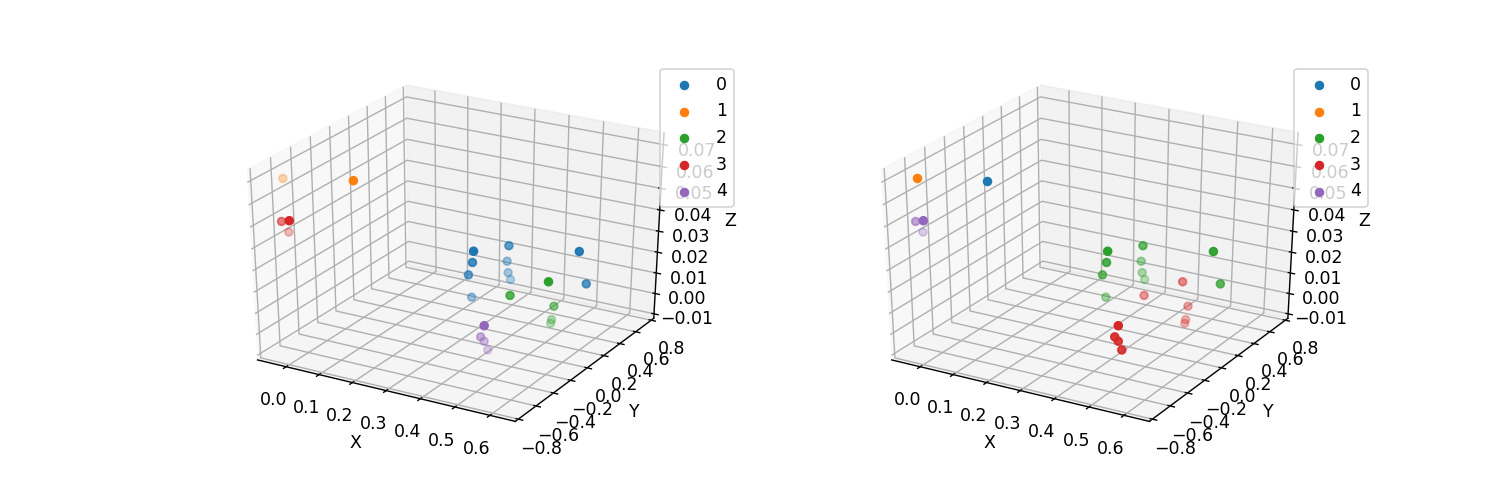

The accuracy for nut and bolt is 0.7015130674002751


In [76]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat = agglomerative(coord_concat_ext, 'cosine', thres = None, n_clusters = 5)
n_original = selected_data.shape[0]

fig = plt.figure(4, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat, selected_label_int)}')

In [78]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat = agglomerative(coord_concat_ext, 'cosine', thres = None, n_clusters = 5)
    n_original = selected_data.shape[0]

    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8179517589343439


# Kmeans with p_norm and number of clusters. 

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)


<IPython.core.display.Javascript object>


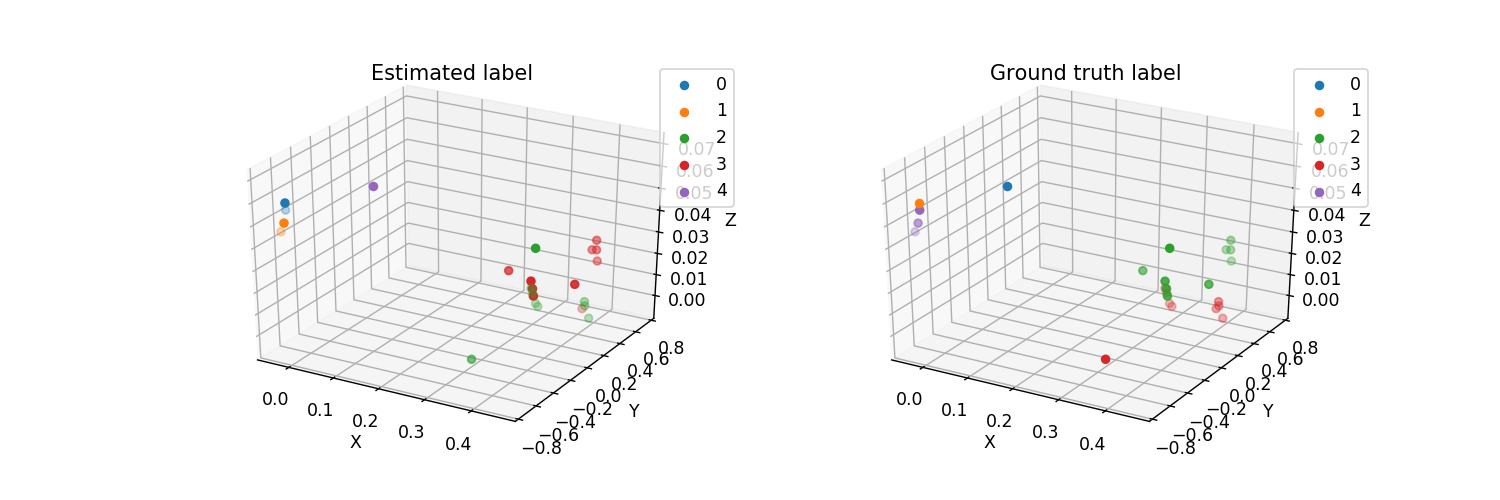

The accuracy for nut and bolt is 0.6823441582680104


In [79]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'p_norm', p = -2)
n_original = selected_data.shape[0]

fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [80]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'p_norm', p = -2)
    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[

0.571539588935993


# Kmeans with Euclidean and number of clusters. 

<IPython.core.display.Javascript object>


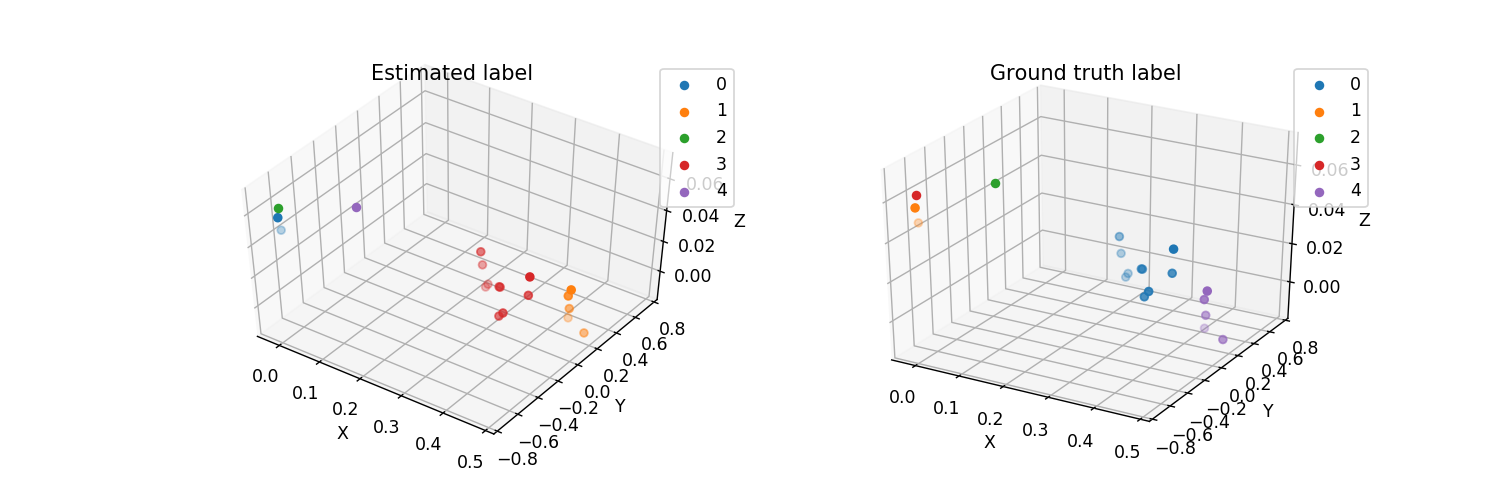

The accuracy for nut and bolt is 1.0


In [9]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'euclidean')
n_original = selected_data.shape[0]

fig = plt.figure(6, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [82]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'euclidean')
    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.9024920268916417


# Kmeans with Cosine and number of clusters. 

<IPython.core.display.Javascript object>


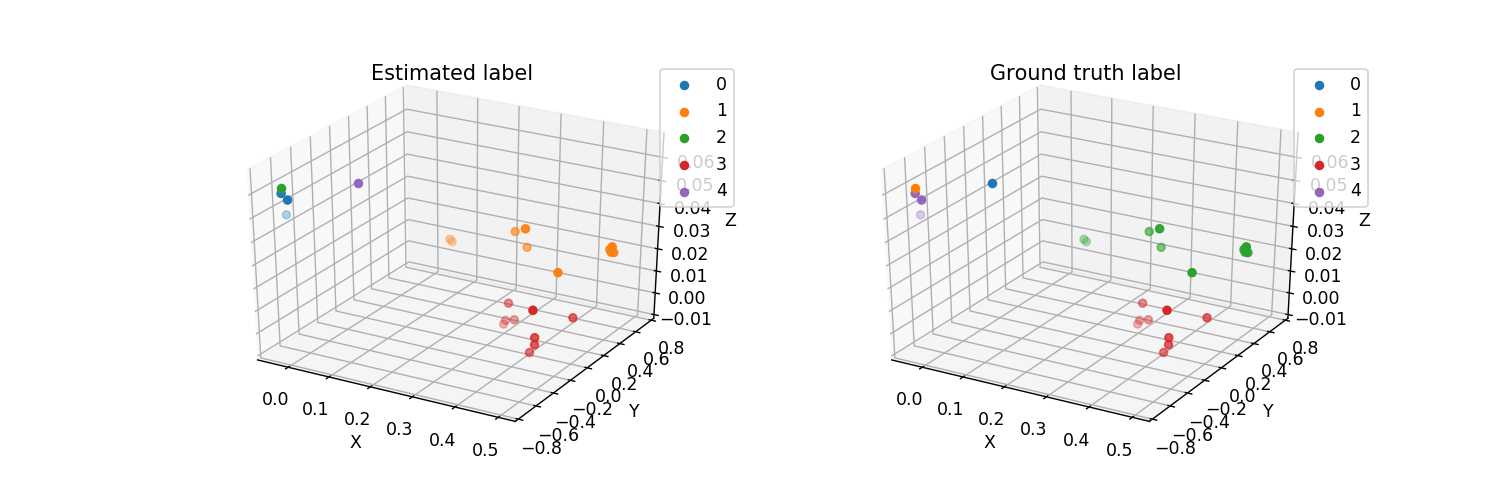

The accuracy for nut and bolt is 1.0


In [86]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'cosine')
n_original = selected_data.shape[0]

fig = plt.figure(7, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [85]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat, centers = kmeans(coord_concat_ext, n_clusters = 5, affinity = 'cosine')
    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8245833457345784


# Gaussian mixture model

<IPython.core.display.Javascript object>


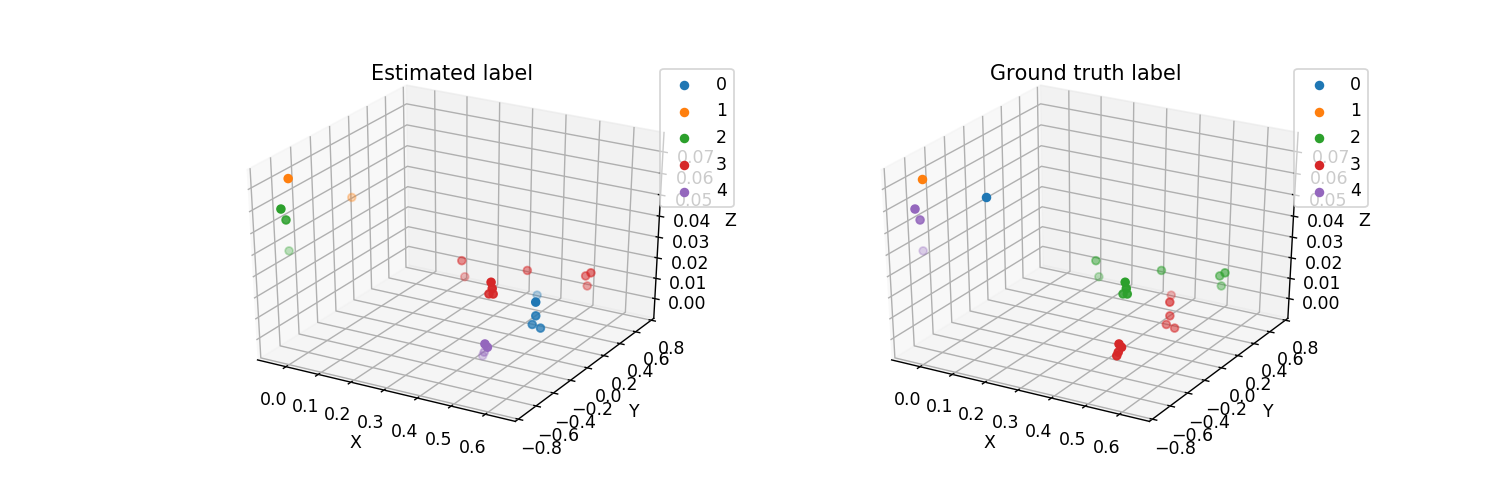

The accuracy for nut and bolt is 0.8081048867699643


In [89]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)
# selected_label_int = label_to_int(selected_label)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

# coord = selected_data[:,0:3]
# obj_kind = selected_data[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot_kind = np.zeros((n_data,2))
one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
# ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
ind_jig = np.delete(np.arange(n_data), ind_table)
one_hot_anchor = np.zeros((n_data,2))
one_hot_anchor[ind_table,0] = 1
one_hot_anchor[ind_jig,1] = 1
noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

estimated_label_concat, centers = gaussian_mixture(coord_concat_ext, n_clusters = 5)
n_original = selected_data.shape[0]

fig = plt.figure(8, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [88]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))
    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)
    # selected_label_int = label_to_int(selected_label)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    # coord = selected_data[:,0:3]
    # obj_kind = selected_data[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot_kind = np.zeros((n_data,2))
    one_hot_kind[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot_kind - np.column_stack((noise_kind, noise_kind)))

    ind_table = np.concatenate((np.where(selected_label_balanced == 'Nut on table')[0], np.where(selected_label_balanced == 'Bolt on table')[0]))
    # ind_table = np.concatenate((np.where(selected_label == 'Nut on table')[0], np.where(selected_label == 'Bolt on table')[0]))
    ind_jig = np.delete(np.arange(n_data), ind_table)
    one_hot_anchor = np.zeros((n_data,2))
    one_hot_anchor[ind_table,0] = 1
    one_hot_anchor[ind_jig,1] = 1
    noise_anchor = np.random.normal(u_anchor, sigma_anchor, obj_kind.size)
    anchor_noisy = abs(one_hot_anchor - np.column_stack((noise_anchor, noise_anchor)))

    coord_concat_ext = np.concatenate((coord_noisy, kind_noisy, anchor_noisy), axis = 1)

    estimated_label_concat, centers = gaussian_mixture(coord_concat_ext, n_clusters = 5)
    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8190101493559123
